<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/2_obtencion_preparacion_exploracion_datos/2_3_indicadores_tecnicos_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2_3_Análisis de indicadores técnicos




## 0. Clonado de repositorio, importación de librerías y carga del dataset

### Clonado de repositorio e importación de librerías

In [ ]:
#Clonamos el repo
#LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

!git clone https://github.com/GUNAPILLCO/neural_profit.git

Cloning into 'neural_profit'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 190 (delta 67), reused 29 (delta 17), pack-reused 89 (from 1)
Receiving objects: 100% (190/190), 108.60 MiB | 11.96 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (41/41), done.


In [ ]:
import sys

#Instalación de librería pandas_market_calendars
#!{sys.executable} -m pip install -q pandas_market_calendars
#print("Librería instalada: pandas_market_calendars")

!{sys.executable} -m pip install -q ta
print("Librería instalada: technical-analysis")

# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import ta
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

from ta.momentum import StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange

from scipy.stats import spearmanr


  Preparing metadata (setup.py) ... done
Librería instalada: technical-analysis


### Carga del dataset mnq_intraday_data

In [ ]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    # Reordenar columnas: 'date', 'time_str', y luego el resto
    cols = ['date'] + [col for col in df.columns if col not in ['date']]

    df = df[cols]

    return df

In [ ]:
mnq_intraday = load_df()

## 1. Definición de Target

Se utiliza el retorno futuro a 30 minutos (target_return_30) como variable objetivo del modelo porque, tras evaluar múltiples hipótesis de predicción, fue el horizonte temporal con mayor IC medio para los indicadores técnicos seleccionados.

Por lo tanto, usaremos los indicadores técnicos para analizar el comportamiento de dicha variable objetivo.



In [ ]:
def add_targets (df):
  df['target_return_30'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
  return df

In [ ]:
mnq_intraday = add_targets(mnq_intraday)

In [ ]:
mnq_intraday

,date,open,high,low,close,volume,target_return_30
datetime,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,0.000372
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,0.000286
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000315
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,0.000315
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000458
...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN


## 2. Indicadores Técnicos

Los indicadores técnicos calculados en cada jornada tienen como objetivo capturar dinámicas intradía relevantes del precio y el volumen, tales como momentum, sobrecompra/sobreventa, presión institucional o posibles reversiones. Cada uno aporta información complementaria sobre el comportamiento del mercado a corto plazo. En particular:

### 2.1. **RSI (Relative Strength Index)**

Mide la fuerza relativa del precio en los últimos períodos (3, 5, 7, 14), oscilando entre 0 y 100.

  - Valores altos indican posibles condiciones de sobrecompra, mientras que valores bajos sugieren sobreventa.
  
  - Calculado sobre los precios de cierre intradía, el RSI es útil para identificar puntos de reversión potenciales en el corto plazo.

In [ ]:
def calcular_rsi(df=mnq_intraday, target='target_return_30' ):
  rsi_columns = ['rsi_14', 'rsi_7', 'rsi_5', 'rsi_3']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['rsi_14'] = ta.momentum.RSIIndicator(grupo[target], window=14).rsi()
        grupo['rsi_7'] = ta.momentum.RSIIndicator(grupo[target], window=7).rsi()
        grupo['rsi_5'] = ta.momentum.RSIIndicator(grupo[target], window=5).rsi()
        grupo['rsi_3'] = ta.momentum.RSIIndicator(grupo[target], window=3).rsi()
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, rsi_columns

### 2.2. **Momentum**

Mide la aceleración reciente del precio mediante la variación porcentual entre el precio actual y el de hace N minutos.

  - Un valor positivo indica una subida reciente, lo que podría sugerir una continuación alcista.

  - Un valor negativo señala presión bajista reciente, potencialmente anticipando una continuación a la baja.

In [ ]:
def calcular_momentum(df=mnq_intraday, target='target_return_30' ):
  momentum_columns = ['momentum_10', 'momentum_5','momentum_3']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['momentum_10'] = grupo[target].pct_change(10)
        grupo['momentum_5'] = grupo[target].pct_change(5)
        grupo['momentum_3'] = grupo[target].pct_change(3)
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, momentum_columns

### 2.3. **Relación de volumen actual vs. su promedio reciente**

Compara el volumen actual con su media móvil en distintas ventanas de tiempo: 15, 20 y 30 minutos.

  - Un valor mayor a 1 indica un volumen superior al promedio de la ventana correspondiente, lo que puede reflejar interés creciente o actividad institucional.

  - Un valor menor a 1 sugiere baja actividad o consolidación del precio.

Esta métrica permite detectar aumentos de volumen ("spikes") sin depender del volumen en crudo, y las diferentes ventanas permiten capturar variaciones en la dinámica de corto plazo con distinta sensibilidad.


In [ ]:
def calcular_volumen_ratio(df=mnq_intraday, target='target_return_30'):
  volume_ratio_columns = ['volume_ratio_15', 'volume_ratio_20', 'volume_ratio_30']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['volume_ratio_15'] = grupo['volume'] / grupo['volume'].rolling(15).mean()
        grupo['volume_ratio_20'] = grupo['volume'] / grupo['volume'].rolling(20).mean()
        grupo['volume_ratio_30'] = grupo['volume'] / grupo['volume'].rolling(30).mean()
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

  return df, volume_ratio_columns

### 2.4. **MACD diferencial (señal de cruce)**

Representa la diferencia entre la línea MACD y su línea de señal (una media exponencial de sí misma).

  - Un valor positivo y creciente indica momentum alcista.

  - Un valor negativo sugiere presión bajista.
  
Es ampliamente utilizado para detectar giros de tendencia y cambios en la dinámica del mercado.


In [ ]:
def calcular_macd(df=mnq_intraday, target='target_return_30'):
    macd_columns = ['macd']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['macd'] = ta.trend.MACD(grupo[target]).macd_diff()
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, macd_columns

### 2.5. **Distancia del precio actual a su EMA (15, 20 y 30 minutos)**

Mide el desvío porcentual del precio respecto a su media exponencial en diferentes ventanas, y actúa como indicador de sobreextensión o retorno a la media.

  - Si el precio está muy por encima de la EMA, puede anticipar una reversión bajista o una posible aceleración alcista.

  - Si está por debajo, podría indicar agotamiento o presión vendedora.<br>

Esta métrica se expresa como un porcentaje relativo, lo que facilita la comparación entre distintas ventanas temporales y condiciones de mercado.

Usar varias ventanas (15, 20 y 30 minutos) permite capturar diferentes horizontes de reacción del precio frente a su media móvil.


In [ ]:
def calcular_ema(df=mnq_intraday, target='target_return_30'):
    ema_columns = ['price_ema15', 'price_ema20', 'price_ema30']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['price_ema15'] = grupo[target] / grupo[target].ewm(span=15).mean() - 1
        grupo['price_ema20'] = grupo[target] / grupo[target].ewm(span=20).mean() - 1
        grupo['price_ema30'] = grupo[target] / grupo[target].ewm(span=30).mean() - 1
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, ema_columns

### 2.6. **%K Estocástico**

Mide la posición relativa del precio actual dentro del rango alto-bajo de los últimos n periodos (generalmente 14).

  - Se utiliza para identificar condiciones extremas de sobrecompra o sobreventa.

  - Un valor cercano a 100 indica que el precio está cerca del máximo reciente (potencial sobrecompra), mientras que un valor cercano a 0 indica proximidad al mínimo reciente (posible sobreventa).

Es útil para detectar momentos en los que el precio puede estar excesivamente extendido y susceptible a una reversión.


In [ ]:
def calcular_stochastic(df=mnq_intraday, target='target_return_30'):
    stoch_columns = ['stoch_k_14', 'stoch_k_20', 'stoch_k_30']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()

        stoch_14 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=14, smooth_window=3
        )
        grupo['stoch_k_14'] = stoch_14.stoch()

        stoch_20 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=20, smooth_window=3
        )
        grupo['stoch_k_20'] = stoch_20.stoch()

        stoch_30 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=30, smooth_window=3
        )
        grupo['stoch_k_30'] = stoch_30.stoch()

        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, stoch_columns


### 2.7.**%B de Bollinger (Bollinger Band Percent)**

Indica la posición del precio actual en relación con las bandas de Bollinger, que están construidas alrededor de una media móvil usando desviaciones estándar.

  - Un valor de %B > 1 sugiere que el precio está por encima de la banda superior, lo que podría implicar exceso de optimismo o momentum fuerte.

  - Un valor < 0 indica que está por debajo de la banda inferior, posible señal de pánico o sobreventa extrema.

Este indicador es eficaz para identificar zonas de congestión, breakout o reversiones basadas en la volatilidad reciente.


In [ ]:
from ta.volatility import BollingerBands

def calcular_bollinger(df=mnq_intraday, target='target_return_30'):
    bollinger_columns = [
        'bb_percent_15_15', 'bb_percent_20_15', 'bb_percent_30_15',
        'bb_percent_15_20', 'bb_percent_20_20', 'bb_percent_30_20',
        'bb_percent_15_25', 'bb_percent_20_25', 'bb_percent_30_25',
    ]

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()

        # std: 1.5
        grupo['bb_percent_15_15'] = BollingerBands(grupo[target], window=15, window_dev=1.5).bollinger_pband()
        grupo['bb_percent_20_15'] = BollingerBands(grupo[target], window=20, window_dev=1.5).bollinger_pband()
        grupo['bb_percent_30_15'] = BollingerBands(grupo[target], window=30, window_dev=1.5).bollinger_pband()

        # std: 2
        grupo['bb_percent_15_20'] = BollingerBands(grupo[target], window=15, window_dev=2).bollinger_pband()
        grupo['bb_percent_20_20'] = BollingerBands(grupo[target], window=20, window_dev=2).bollinger_pband()
        grupo['bb_percent_30_20'] = BollingerBands(grupo[target], window=30, window_dev=2).bollinger_pband()

        # std: 2.5
        grupo['bb_percent_15_25'] = BollingerBands(grupo[target], window=15, window_dev=2.5).bollinger_pband()
        grupo['bb_percent_20_25'] = BollingerBands(grupo[target], window=20, window_dev=2.5).bollinger_pband()
        grupo['bb_percent_30_25'] = BollingerBands(grupo[target], window=30, window_dev=2.5).bollinger_pband()

        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, bollinger_columns


### 2.8. **ATR normalizado (Average True Range / precio)**

Representa la volatilidad absoluta reciente ajustada al nivel del precio.

  - El ATR mide el rango promedio de oscilación de un activo en los últimos n periodos, capturando tanto movimientos bruscos como gaps.

  - Al normalizarlo dividiéndolo por el precio, se obtiene una medida relativa, comparable entre distintos niveles de mercado.

Este indicador es útil para detectar momentos de alta o baja volatilidad intradía, que pueden influir en la confiabilidad de otras señales técnicas.


In [ ]:
def calcular_atr(df=mnq_intraday, target='target_return_30'):
    atr_columns = ['atr_norm']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        grupo['atr'] = atr.average_true_range()
        grupo['atr_norm'] = grupo['atr'] / grupo[target]
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, atr_columns


### 2.9. **ROC (Rate of Change)**

Calcula la tasa de cambio porcentual del precio con respecto a su valor n minutos atrás.

- Es un indicador de momentum que capta aceleraciones o desaceleraciones recientes del precio.

- Valores positivos indican presión alcista; negativos, presión bajista.

A diferencia del momentum tradicional, el ROC expresa el cambio de forma normalizada y en porcentaje, lo que facilita su interpretación comparativa entre distintos activos o marcos temporales.


In [ ]:
def calcular_roc(df=mnq_intraday, target='target_return_30'):
    roc_columns = ['roc_5']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['roc_5'] = ROCIndicator(close=grupo[target], window=5).roc()
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, roc_columns

##3. Calculo de Information Coefficient (IC)

El Information Coefficient (IC) es la correlación de Spearman entre el factor y el retorno futuro. Mide si el ranking del factor predice el ranking del retorno.

- IC > 0: el factor tiene relación positiva → valores altos del factor tienden a preceder retornos positivos.

- IC < 0: relación inversa → valores altos del factor tienden a preceder retornos negativos (reversión).

- IC ≈ 0: el factor es probablemente ruido o no tiene señal útil.

Valores comunes en finanzas:

- Entre 0.05 a 0.1: débil pero útil.

- Mayor a 0.1: muy raro, pero fuerte.

- Menor 0.05 o cercano a 0: probablemente ruido.

### **Función para calcular IC:**

In [ ]:
def calcular_IC(df: pd.DataFrame, target: str, factors: list[str]):
    grouped = df.groupby('date')

    print(f"IC promedio por factor (diario) sobre el {target}:\n")

    resultados = []

    for factor in factors:
        daily_ics = []

        for date, group in grouped:
            df_valid = group[[factor, target]].dropna()
            if len(df_valid) >= 20:
                ic = spearmanr(df_valid[factor], df_valid[target]).correlation
                if np.isfinite(ic):
                    daily_ics.append(ic)

        if daily_ics:
            mean_ic = np.mean(daily_ics)
            std_ic = np.std(daily_ics)
            dias_validos = len(daily_ics)
            print(f"{factor:15}: IC medio = {mean_ic:.4f} | std = {std_ic:.4f} | días válidos = {dias_validos}")
            resultados.append({
                'factor': factor,
                'ic_mean': mean_ic,
                'ic_std': std_ic,
                'dias_validos': dias_validos
            })
        else:
            print(f"{factor:15}: sin días válidos para cálculo")

    return pd.DataFrame(resultados)

### 3.1. **RSI (Relative Strength Index)**

In [ ]:
mnq_rsi, rsi_cols = calcular_rsi()
IC_rsi = calcular_IC(mnq_rsi, 'target_return_30', rsi_cols)

IC promedio por factor (diario) sobre el target_return_30:

rsi_14         : IC medio = 0.6387 | std = 0.0666 | días válidos = 1311
rsi_7          : IC medio = 0.4740 | std = 0.0582 | días válidos = 1311
rsi_5          : IC medio = 0.3995 | std = 0.0539 | días válidos = 1311
rsi_3          : IC medio = 0.3040 | std = 0.0471 | días válidos = 1311


#### 3.1.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario |
|-----------|----------|----------------|------------|
| `rsi_14`  | 0.6387   | 0.0666         | Muy fuerte y consistente. |
| `rsi_7`   | 0.4740   | 0.0582         | Robusto, aunque menor que `rsi_14`. |
| `rsi_5`   | 0.3995   | 0.0539         | Señal moderada. |
| `rsi_3`   | 0.3040   | 0.0471         | Menor poder predictivo. |

<br>

- El IC promedio decrece a medida que la ventana del RSI se acorta, lo que sugiere que las señales más estables y suavizadas (como `rsi_14`) se correlacionan mejor con el comportamiento del precio a 30 minutos.

- `rsi_14` destaca claramente como el más informativo, no solo por su IC medio alto (0.6387), sino también por su baja desviación estándar (0.0666), lo que indica consistencia en distintos días.

- Los RSI con ventanas más cortas (`rsi_3`, `rsi_5`, `rsi_7`) muestran un poder predictivo decreciente. Aunque pueden aportar información, son menos efectivos para este horizonte de predicción.


#### 3.1.2. Recomendaciones

- Priorizar `rsi_14` como alpha factor principal para el modelo de predicción a 30 minutos.

- Considerar también `rsi_7` como alternativa o complemento.

- No es necesario incluir todos los RSI simultáneamente. Para evitar multicolinealidad o sobreajuste, se recomienda aplicar técnicas de selección de variables (como regularización o análisis de redundancia).

### 3.2. **Momentum**

In [ ]:
mnq_momentum, momentum_cols = calcular_momentum()
IC_momentum = calcular_IC(mnq_momentum, 'target_return_30', momentum_cols)

IC promedio por factor (diario) sobre el target_return_30:

momentum_10    : IC medio = 0.0334 | std = 0.1975 | días válidos = 1311
momentum_5     : IC medio = 0.0315 | std = 0.1653 | días válidos = 1311
momentum_3     : IC medio = 0.0290 | std = 0.1405 | días válidos = 1311


#### 3.2.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                        |
|---------------|----------|----------------|-----------------------------------|
| `momentum_10` | 0.0334   | 0.1975         | Muy bajo poder predictivo, ruidoso. |
| `momentum_5`  | 0.0315   | 0.1653         | Similar a `momentum_10`, poca utilidad. |
| `momentum_3`  | 0.0290   | 0.1405         | Levemente más estable, pero irrelevante. |

<br>

- Todos los indicadores de momentum muestran **IC promedio cercano a cero**, lo que indica **bajo poder predictivo** sobre el retorno a 30 minutos.

- Además, presentan **desviaciones estándar elevadas**, reflejando **alta inestabilidad diaria** en su comportamiento.

- No se observa mejora al cambiar la ventana (3, 5 o 10 minutos), lo que sugiere que este indicador técnico no capta dinámicas relevantes para el horizonte temporal evaluado.




#### 3.2.2. Recomendaciones

- **No se recomienda incluir los indicadores técnicos `momentum_3`, `momentum_5` ni `momentum_10`** como alpha factors en el modelo.

- Su bajo IC y alta varianza indican que **aportan más ruido que señal** en la predicción del retorno a 30 minutos.

- Es preferible priorizar otros indicadores con mayor estabilidad y poder explicativo.

### 3.3. **Relación de volumen actual vs. su promedio reciente**

In [ ]:
mnq_volumen, volumen_cols = calcular_volumen_ratio()
IC_volumen = calcular_IC(mnq_volumen, 'target_return_30', volumen_cols)

IC promedio por factor (diario) sobre el target_return_30:

volume_ratio_15: IC medio = 0.0053 | std = 0.0643 | días válidos = 1311
volume_ratio_20: IC medio = 0.0048 | std = 0.0785 | días válidos = 1311
volume_ratio_30: IC medio = 0.0051 | std = 0.1039 | días válidos = 1311


#### 3.3.1. Conclusiones

| Indicador         | IC medio | Desv. Estándar | Comentario                              |
|-------------------|----------|----------------|------------------------------------------|
| `volume_ratio_15` | 0.0053   | 0.0643         | Extremadamente bajo, sin relevancia.     |
| `volume_ratio_20` | 0.0048   | 0.0785         | Similar resultado, algo más inestable.   |
| `volume_ratio_30` | 0.0051   | 0.1039         | Ligeramente más volátil, igual de débil. |

<br>

- Todos los indicadores `volume_ratio` presentan un **IC medio cercano a cero**, lo cual indica que **no tienen capacidad predictiva significativa** sobre el retorno a 30 minutos.

- A pesar de su baja desviación estándar (en especial en `volume_ratio_15`), los valores de IC son **demasiado bajos como para ser considerados útiles**.

- Aumentar la ventana de promedio (15 → 30) no mejora el desempeño, sino que incluso **incrementa la varianza**.


#### 3.3.2. Recomendaciones

- **No se recomienda utilizar los indicadores `volume_ratio_15`, `volume_ratio_20` ni `volume_ratio_30`** como alpha factors.

- Su incapacidad para capturar una señal útil para el horizonte temporal evaluado los vuelve **prescindibles en el modelo**.

- En su lugar, conviene enfocarse en factores de precio o volatilidad con mejor desempeño estadístico.


### 3.4. **MACD diferencial (señal de cruce)**

In [ ]:
mnq_macd, macd_cols = calcular_macd()
IC_macd = calcular_IC(mnq_macd, 'target_return_30', macd_cols)

IC promedio por factor (diario) sobre el target_return_30:

macd           : IC medio = 0.1962 | std = 0.0984 | días válidos = 1311


#### 3.4.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario                            |
|-----------|----------|----------------|----------------------------------------|
| `macd`    | 0.1962   | 0.0984         | Señal moderada, con estabilidad aceptable. |

<br>

- El indicador `macd` muestra un **IC medio positivo (0.1962)**, lo cual sugiere que tiene **cierta capacidad predictiva** sobre el retorno a 30 minutos.

- Su desviación estándar (0.0984) es **moderada**, lo que indica un nivel de **consistencia razonable** a lo largo de los días.

- Aunque no alcanza la fuerza predictiva de otros factores como `rsi_14` o `bb_percent_30_20`, el MACD ofrece una **señal útil y complementaria**, especialmente en entornos de tendencia.


#### 3.4.2. Recomendaciones

- Se puede **incluir `macd` como alpha factor secundario**, aportando valor en combinación con otros indicadores más fuertes.

- Su uso es particularmente relevante si el modelo incorpora señales de momentum o detección de cambios de tendencia.

- Es aconsejable validarlo dentro de un conjunto de features para evaluar su contribución marginal.

### 3.5. **Distancia del precio actual a su EMA (15, 20 y 30 minutos)**

In [ ]:
mnq_ema, ema_cols = calcular_ema()
IC_ema = calcular_IC(mnq_ema, 'target_return_30', ema_cols)

IC promedio por factor (diario) sobre el target_return_30:

price_ema15    : IC medio = 0.0207 | std = 0.1361 | días válidos = 1311
price_ema20    : IC medio = 0.0226 | std = 0.1600 | días válidos = 1311
price_ema30    : IC medio = 0.0251 | std = 0.1960 | días válidos = 1311


#### 3.5.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                                   |
|---------------|----------|----------------|-----------------------------------------------|
| `price_ema15` | 0.0207   | 0.1361         | Muy débil, con alta variabilidad.             |
| `price_ema20` | 0.0226   | 0.1600         | Ligera mejora, pero aún irrelevante.          |
| `price_ema30` | 0.0251   | 0.1960         | Ligeramente más estable, pero poco útil.      |

<br>

- Todos los indicadores basados en la distancia al EMA presentan **IC medios extremadamente bajos**, lo que indica **muy baja capacidad predictiva** para anticipar el retorno a 30 minutos.

- Aumentar la ventana de la EMA de 15 a 30 no mejora sustancialmente el desempeño; el IC apenas varía y la **desviación estándar aumenta**, lo cual refleja una señal más ruidosa.

- Aunque conceptualmente estos indicadores pueden capturar sobreextensión o reversión, en la práctica **no aportan valor estadístico en este horizonte temporal**.


#### 3.5.2. Recomendaciones

- **No se recomienda incluir `price_ema15`, `price_ema20` ni `price_ema30`** como alpha factors en el modelo actual.

- En su lugar, es preferible utilizar indicadores que midan condiciones extremas desde otros enfoques, como `rsi_14` o `bb_percent_30_20`, que mostraron mucho mejor desempeño.

- Estos indicadores podrían evaluarse nuevamente si se cambia el horizonte de predicción o se combinan con señales de tendencia más fuertes.

### 3.6. **%K Estocástico**

In [ ]:
mnq_stoch, stoch_cols = calcular_stochastic()
IC_stoch = calcular_IC(mnq_stoch, 'target_return_30', stoch_cols)

IC promedio por factor (diario) sobre el target_return_30:

stoch_k_14     : IC medio = 0.0610 | std = 0.1992 | días válidos = 1311
stoch_k_20     : IC medio = 0.0629 | std = 0.2075 | días válidos = 1311
stoch_k_30     : IC medio = 0.0679 | std = 0.2237 | días válidos = 1311


#### 3.6.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                                  |
|---------------|----------|----------------|----------------------------------------------|
| `stoch_k_14`  | 0.0610   | 0.1992         | Señal débil y bastante volátil.              |
| `stoch_k_20`  | 0.0629   | 0.2075         | Sin mejora significativa respecto al anterior. |
| `stoch_k_30`  | 0.0679   | 0.2237         | Leve aumento del IC, pero más inestable aún. |

<br>

- Los valores de IC medio para los tres estocásticos son **muy bajos**, lo que sugiere una **capacidad predictiva limitada** sobre el retorno a 30 minutos.

- Aumentar la ventana de cálculo incrementa ligeramente el IC, pero también **aumenta considerablemente la desviación estándar**, lo que indica que la señal es más inconsistente.

- En general, el indicador parece no alinearse bien con la dinámica del target evaluado, posiblemente por su sensibilidad a oscilaciones de corto plazo.

#### 3.6.2. Recomendaciones

- **No se recomienda incluir `stoch_k_14`, `stoch_k_20` ni `stoch_k_30`** como alpha factors principales.

- Dado su bajo IC y alta varianza, estos indicadores pueden introducir **ruido más que señal** en el modelo.

- Podrían reevaluarse en contextos donde se investigue sobrecompra/sobreventa extrema a horizontes más cortos o en combinación con filtros de tendencia.

### 3.7.**%B de Bollinger (Bollinger Band Percent)**


In [ ]:
mnq_bollinger, bollinger_cols = calcular_bollinger()
IC_bollinger = calcular_IC(mnq_bollinger, 'target_return_30', bollinger_cols)

IC promedio por factor (diario) sobre el target_return_30:

bb_percent_15_15: IC medio = 0.3986 | std = 0.0628 | días válidos = 1311
bb_percent_20_15: IC medio = 0.4619 | std = 0.0670 | días válidos = 1311
bb_percent_30_15: IC medio = 0.5679 | std = 0.0757 | días válidos = 1311
bb_percent_15_20: IC medio = 0.3986 | std = 0.0628 | días válidos = 1311
bb_percent_20_20: IC medio = 0.4619 | std = 0.0670 | días válidos = 1311
bb_percent_30_20: IC medio = 0.5679 | std = 0.0757 | días válidos = 1311
bb_percent_15_25: IC medio = 0.3986 | std = 0.0628 | días válidos = 1311
bb_percent_20_25: IC medio = 0.4619 | std = 0.0670 | días válidos = 1311
bb_percent_30_25: IC medio = 0.5679 | std = 0.0757 | días válidos = 1311


#### 3.7.1. Conclusiones

| Indicador          | Ventana | Desv. Std | IC medio | Desv. Estándar | Comentario                               |
|--------------------|---------|-----------|----------|----------------|-------------------------------------------|
| `bb_percent_15_15` | 15      | 1.5       | 0.3986   | 0.0628         | Señal útil, aunque más sensible.          |
| `bb_percent_20_15` | 20      | 1.5       | 0.4619   | 0.0670         | Buena señal, más estable.                 |
| `bb_percent_30_15` | 30      | 1.5       | 0.5679   | 0.0757         | Muy fuerte, la mejor entre las variantes. |
| `bb_percent_15_20` | 15      | 2.0       | 0.3986   | 0.0628         | Idéntico a `15_15`, no mejora.            |
| `bb_percent_20_20` | 20      | 2.0       | 0.4619   | 0.0670         | Idéntico a `20_15`, igualmente robusto.   |
| `bb_percent_30_20` | 30      | 2.0       | 0.5679   | 0.0757         | Idéntico a `30_15`, excelente señal.      |
| `bb_percent_15_25` | 15      | 2.5       | 0.3986   | 0.0628         | Sin cambios respecto a otras versiones.   |
| `bb_percent_20_25` | 20      | 2.5       | 0.4619   | 0.0670         | Misma efectividad.                        |
| `bb_percent_30_25` | 30      | 2.5       | 0.5679   | 0.0757         | Consistente como las demás de ventana 30. |

<br>

- Los resultados muestran que **el valor de la desviación estándar (`window_dev`) no afecta el desempeño predictivo**: los valores de IC son idénticos para cada ventana, sin importar si se usa 1.5, 2.0 o 2.5.

- En cambio, **la ventana de cálculo (`window`) sí tiene un impacto claro**:
  - A mayor ventana (de 15 a 30), el IC promedio **aumenta significativamente**.
  - `bb_percent_30_*` alcanza un IC medio de **0.5679**, con desviación estándar moderada, lo que la convierte en una de las señales más fuertes evaluadas.

- Esto sugiere que **condiciones de sobrecompra/sobreventa sostenidas en el tiempo** (no picos breves) están más alineadas con movimientos relevantes a 30 minutos.


#### 3.7.2. Recomendaciones

- **Priorizar `bb_percent_30_20`** (o cualquiera de las variantes con ventana 30), dado que muestran el **mayor IC medio** con buena estabilidad.

- No es necesario incluir todas las combinaciones de `bb_percent`; basta con seleccionar la versión más representativa (`window=30`, cualquier `window_dev`).

- Este indicador debe considerarse como uno de los **factores principales en el modelo predictivo**.

### 3.8. **ATR normalizado (Average True Range / precio)**

In [ ]:
mnq_atr, atr_cols = calcular_atr()
IC_atr = calcular_IC(mnq_atr, 'target_return_30', atr_cols)

IC promedio por factor (diario) sobre el target_return_30:

atr_norm       : IC medio = 0.4313 | std = 0.1131 | días válidos = 1311


#### 3.8.1. Conclusiones

| Indicador   | IC medio | Desv. Estándar | Comentario                              |
|-------------|----------|----------------|------------------------------------------|
| `atr_norm`  | 0.4313   | 0.1131         | Señal fuerte y relativamente estable.    |

<br>

- El indicador `atr_norm` (ATR dividido por el precio) muestra un **IC medio elevado (0.4313)**, lo que indica una **buena capacidad predictiva** sobre el retorno a 30 minutos.

- Su desviación estándar (0.1131) es moderada, lo que sugiere un nivel aceptable de **consistencia a lo largo del tiempo**.

- Este resultado valida que la **volatilidad reciente, ajustada por el nivel de precios**, es un factor informativo relevante en el contexto intradía del índice MNQ.


#### 3.8.2. Recomendaciones

- **Incluir `atr_norm` como alpha factor prioritario** en el modelo, ya que aporta una señal sólida que puede complementar otros indicadores de momentum o reversión.

- Dado su poder predictivo y estabilidad, `atr_norm` se posiciona entre los mejores factores evaluados hasta el momento.

### 3.9. **ROC (Rate of Change)**

In [ ]:
mnq_roc, roc_cols = calcular_roc()
IC_roc = calcular_IC(mnq_roc, 'target_return_30', roc_cols)

IC promedio por factor (diario) sobre el target_return_30:

roc_5          : IC medio = 0.0315 | std = 0.1653 | días válidos = 1311


#### 3.9.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario                               |
|-----------|----------|----------------|-------------------------------------------|
| `roc_5`   | 0.0315   | 0.1653         | Señal muy débil y con alta variabilidad.  |

<br>

- El indicador `roc_5`, que mide la tasa de cambio porcentual del precio en los últimos 5 minutos, muestra un **IC medio muy bajo (0.0315)**, lo que indica **escasa capacidad predictiva** sobre el retorno a 30 minutos.

- La desviación estándar (0.1653) es relativamente alta, lo que refleja una señal **inestable y poco confiable**.

- Estos resultados son consistentes con otros indicadores de momentum que también mostraron bajo desempeño en este horizonte temporal.


#### 3.9.2. Recomendaciones

- **No se recomienda incluir `roc_5` como alpha factor** para la predicción del retorno a 30 minutos.

- Su baja señal y alta variabilidad sugieren que **no aporta valor predictivo real** en este contexto.

- Es preferible centrar los modelos en indicadores más robustos como `rsi_14`, `bb_percent_30_20` o `atr_norm`.



## 4. Selección de mejores indicadores técnicos

Las recomendaciones finales de indicadores técnicos son:

**RSI:**

- **`rsi_14` debe ser priorizado** como alpha factor principal, dado que obtuvo el IC medio más alto entre todos los indicadores evaluados, con excelente estabilidad.
- **`rsi_7` puede considerarse como alternativa secundaria**, aportando una señal más reactiva, pero aún robusta y consistente.

**MACD:**

- **`macd` puede incluirse como factor complementario**, especialmente si el modelo incorpora señales de momentum o detección de cambios de tendencia.
- Su poder predictivo es más limitado comparado con otros factores, por lo que **conviene validar su utilidad dentro de un conjunto multivariado**, evaluando su contribución marginal al desempeño general del modelo.

**Bollinger Bands (%B):**

- **`bb_percent_30_20` es la variante más recomendable**, ya que muestra el mayor IC medio con buena estabilidad.
- **`bb_percent_20_20` también es una alternativa sólida**, con buen desempeño y menor ventana, lo que puede ser útil si se buscan señales más rápidas.
- No es necesario conservar todas las combinaciones; basta con **incluir una o dos versiones representativas** (idealmente con `window=30` y/o `window=20`), ya que las demás no aportan valor adicional.
- Este grupo debe considerarse como **una fuente clave de señales predictivas**.

**ATR:**

- **`atr_norm` se destaca como uno de los mejores alpha factors**, combinando un IC alto con estabilidad razonable.
- Su capacidad para capturar volatilidad relativa al precio lo convierte en un complemento valioso para otros factores basados en tendencia o momentum.

### 4.1. Función para agregar mejores indicadores técnicos

In [ ]:
def best_indicators(df=mnq_intraday, target='target_return_30' ):
  best_indicators_list = ['rsi_14', 'rsi_7', 'macd', 'bb_percent_20_20', 'bb_percent_30_20', 'atr_norm']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        #RSI 14 y RSI 7
        grupo['rsi_14'] = ta.momentum.RSIIndicator(grupo[target], window=14).rsi()
        grupo['rsi_7'] = ta.momentum.RSIIndicator(grupo[target], window=7).rsi()

        #MACD
        grupo['macd'] = ta.trend.MACD(grupo[target]).macd_diff()

        #BB PERCENT
        grupo['bb_percent_20_20'] = BollingerBands(grupo[target], window=20, window_dev=2).bollinger_pband()
        grupo['bb_percent_30_20'] = BollingerBands(grupo[target], window=30, window_dev=2).bollinger_pband()

        #ATR Normalizado
        atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        grupo['atr'] = atr.average_true_range()
        grupo['atr_norm'] = grupo['atr'] / grupo[target]
        #atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        #grupo['atr_norm'] = atr.average_true_range() / grupo[target]

        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, best_indicators_list

In [ ]:
mnq_intraday, best_indicators_list = best_indicators()

In [ ]:
IC_ba = calcular_IC(mnq_intraday, 'target_return_30', best_indicators_list)

IC promedio por factor (diario) sobre el target_return_30:

rsi_14         : IC medio = 0.6387 | std = 0.0666 | días válidos = 1311
rsi_7          : IC medio = 0.4740 | std = 0.0582 | días válidos = 1311
macd           : IC medio = 0.1962 | std = 0.0984 | días válidos = 1311
bb_percent_20_20: IC medio = 0.4619 | std = 0.0670 | días válidos = 1311
bb_percent_30_20: IC medio = 0.5679 | std = 0.0757 | días válidos = 1311
atr_norm       : IC medio = 0.4313 | std = 0.1131 | días válidos = 1311


In [ ]:
mnq_intraday

,date,open,high,low,close,volume,target_return_30,rsi_14,rsi_7,macd,bb_percent_30_20,atr_norm,bb_percent_20_20,atr
datetime,,,,,,,,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,0.000372,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,0.000286,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000315,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,0.000315,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000458,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN,63.154131,77.443346,8.095646e-07,NaN,NaN,NaN,3412.904825
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN,63.154131,77.443346,6.476516e-07,NaN,NaN,NaN,3170.518766
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN,63.154131,77.443346,5.181213e-07,NaN,NaN,NaN,2945.213855


In [ ]:
best_indicators_list

['rsi_14', 'rsi_7', 'macd', 'bb_percent_20_20', 'bb_percent_30_20', 'atr_norm']

## 5. Análisis del IC durante el día.

### 5.1. Funciones

#### Función para plotear el comportamiento

In [ ]:
def plot_ic_tecnicos_por_minuto(df: pd.DataFrame,
                                 factors: list[str],
                                 target: str,
                                 date_col: str = 'date'):
    """
    Calcula y grafica el IC por minuto intradía para una lista de indicadores técnicos.
    El eje X muestra el tiempo intradía (desde las 08:00 AM).
    """

    df = df.copy()
    df['minute_index'] = df.groupby(date_col).cumcount()

    def compute_ic_series(factor_col, target_col):
        grouped = df[[factor_col, target_col, 'minute_index']].dropna()
        return grouped.groupby('minute_index').apply(
            lambda x: x[factor_col].corr(x[target_col])
        )

    # Calcular IC por minuto para cada factor
    ic_series = {factor: compute_ic_series(factor, target) for factor in factors}

    # Eje X: minutos del día y etiquetas horarias
    xticks = np.arange(0, 451, 30)
    start_time = pd.to_datetime("08:00")
    time_labels = [(start_time + pd.Timedelta(minutes=i)).strftime("%H:%M") for i in xticks]

    # Graficar
    plt.figure(figsize=(15, 6))
    for factor, ic in ic_series.items():
        plt.plot(ic.index, ic, label=factor)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'IC por minuto del día - Target: {target}')
    plt.xlabel('Hora intradía')
    plt.ylabel('Information Coefficient (IC)')
    plt.xticks(ticks=xticks, labels=time_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ic_series

#### Función para analizar los mejores y peores IC durante el día

In [ ]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame,
                                 mode: str = 'worst',
                                 top_n: int = 30,
                                 market_open: str = "08:00") -> pd.DataFrame:
    """
    Analiza series de IC minuto a minuto para distintos alpha factors.
    Retorna el IC mínimo, IC máximo, y el promedio de los top_n peores o mejores ICs,
    indicando la hora exacta en la que ocurren los extremos.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)
    - mode: 'worst' para los peores ICs, 'best' para los mejores ICs
    - top_n: cantidad de valores extremos a promediar
    - market_open: hora de inicio del mercado en formato "HH:MM" (por defecto 08:30)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los ICs extremos
    """
    results = []
    base_time = pd.to_datetime(market_open)

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()

        if mode == 'worst':
            extreme_vals = series.nsmallest(top_n)
        elif mode == 'best':
            extreme_vals = series.nlargest(top_n)
        else:
            raise ValueError("El parámetro 'mode' debe ser 'worst' o 'best'.")

        extreme_mean = extreme_vals.mean()

        # IC mínimo y su hora
        min_ic = series.min()
        min_minute = series.idxmin()
        min_time = (base_time + pd.Timedelta(minutes=min_minute)).strftime("%H:%M")

        # IC máximo y su hora
        max_ic = series.max()
        max_minute = series.idxmax()
        max_time = (base_time + pd.Timedelta(minutes=max_minute)).strftime("%H:%M")

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Hora del IC mínimo': min_time,
            'IC máximo': max_ic,
            'Hora del IC máximo': max_time,
            f'Promedio de los {top_n} {"peores" if mode == "worst" else "mejores"} ICs': extreme_mean
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    sort_col = result_df.columns[-1]
    result_df = result_df.sort_values(sort_col, ascending=(mode == 'worst'))

    return result_df

### 5.2. Gráfico de comportamiento

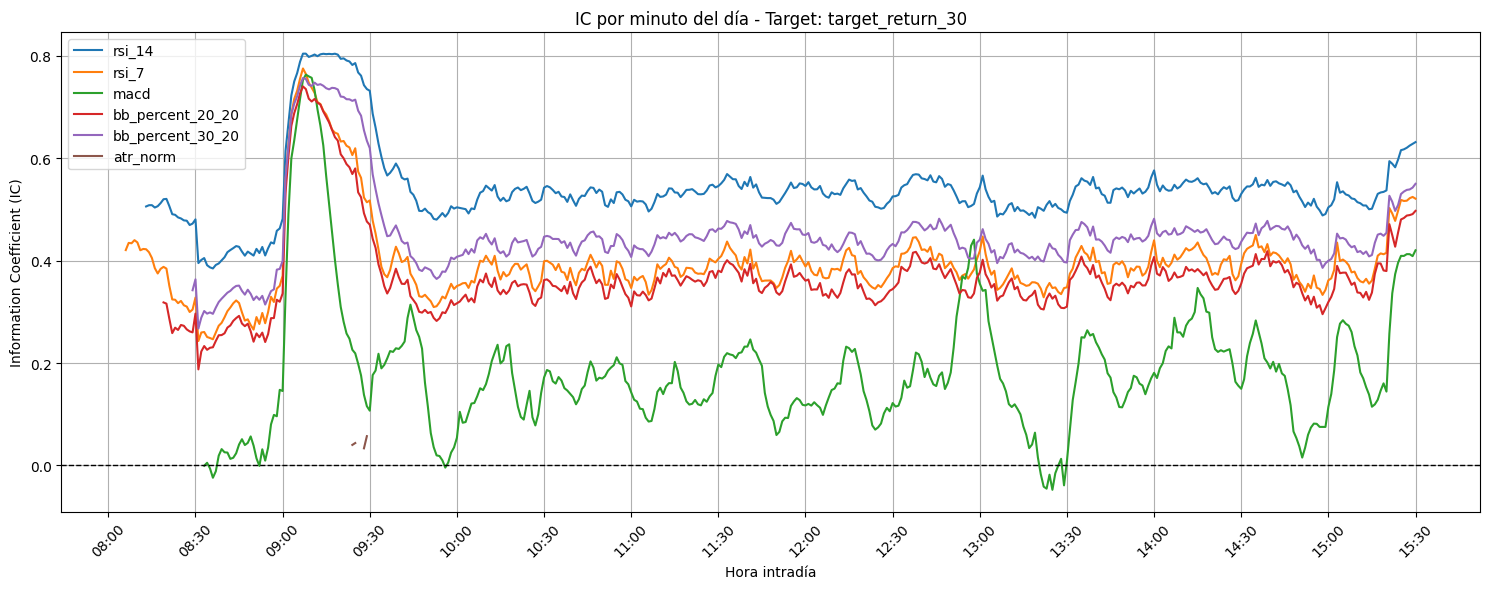

In [ ]:
# 1. Calcular el IC por minuto para los mejores factores
ic_por_minuto = plot_ic_tecnicos_por_minuto(mnq_intraday, best_indicators_list, target='target_return_30')

Este gráfico muestra la evolución intradía del Information Coefficient (IC) minuto a minuto para los principales indicadores técnicos seleccionados.

`rsi_14`
- Se mantiene como el mejor factor durante todo el día.
- Alcanza su pico entre las 09:00 y 09:30, superando un IC de 0.8.
- Conserva valores superiores a 0.5 durante toda la jornada, mostrando alta estabilidad y poder predictivo constante.

`rsi_7`
- Fuerte tras la apertura, con un IC que supera 0.6 momentáneamente.
- Posteriormente se estabiliza entre 0.35 y 0.4, ofreciendo una señal secundaria útil pero menos potente que `rsi_14`.

`macd`
- Muestra un comportamiento altamente volátil, con picos de IC positivos pasando las 09:00, pero también caídas frecuentes.
- A menudo oscila cerca de 0 o incluso bajo cero, lo que indica baja consistencia y sensibilidad al horario.

`bb_percent_30_20`
- Tiene un rendimiento excelente en la apertura con IC > 0.75.
- A lo largo del día se estabiliza entre 0.4 y 0.5, lo que lo posiciona como un factor muy sólido y confiable.

`bb_percent_20_20`
- Similar comportamiento al `rsi_7`, con un IC inicial alto seguido de valores constantes entre 0.3 y 0.4.
- Es una alternativa válida, aunque menos destacada que su versión con ventana 30.

`atr_norm`
- Presenta un IC bajo, generalmente en torno a 0.05, pero con una estabilidad notable.
- Aunque no aporta una señal fuerte, podría actuar como factor complementario, especialmente por su carácter defensivo y constante.

<br>

**Conclusión general**

- La primera hora de negociación (08:30–09:30) concentra el mayor poder predictivo de los indicadores técnicos.
- `rsi_14` y `bb_percent_30_20` son los factores más efectivos, mostrando IC alto y sostenido a lo largo del día.
- `macd` es el más inestable, útil solo en ciertos momentos.
- `atr_norm` es el más constante, pero tiene bajo poder predictivo relativo.

### 5.3. Peores IC durante el día

In [ ]:
# 2. Convertir el dict a DataFrame para análisis de extremos
ic_minute_df = pd.DataFrame(ic_por_minuto)

# 3. Analizar los peores momentos del día para cada factor
print('\nPeores momentos de IC:\n')
peores_horas = analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)
display(peores_horas)


Peores momentos de IC:



,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
macd,-0.047733,13:25,0.763289,09:08,-0.001461
atr_norm,0.033304,09:28,0.057095,09:29,0.042557
bb_percent_20_20,0.187528,08:31,0.740279,09:07,0.253421
rsi_7,0.242861,08:31,0.775382,09:07,0.284903
bb_percent_30_20,0.267360,08:31,0.756700,09:07,0.327201
rsi_14,0.384683,08:36,0.804358,09:08,0.416709


**Interpretación de los 30 peores ICs (por minuto)**

<br>

| Alpha Factor       | IC mínimo | Hora del IC mínimo | Promedio de los 30 peores ICs | Interpretación                                                  |
|--------------------|-----------|---------------------|-------------------------------|-----------------------------------------------------------------|
| `macd`             | -0.0477   | 13:25               | -0.0015                        | Puede volverse ligeramente inverso o errático cerca del cierre. |
| `atr_norm`         | 0.0333    | 09:28               | 0.0426                         | Muy estable, aunque con bajo IC en general.                     |
| `bb_percent_20_20` | 0.1875    | 08:31               | 0.2534                         | Bajo IC justo al comienzo del día.                              |
| `rsi_7`            | 0.2429    | 08:31               | 0.2849                         | Señal más débil al inicio, pero aún aceptable.                  |
| `bb_percent_30_20` | 0.2674    | 08:31               | 0.3272                         | También más débil al arranque, pero muy útil.                   |
| `rsi_14`           | 0.3847    | 08:36               | 0.4167                         | Incluso su "peor" desempeño es sólido.                          |

**Conclusión**:

- Los peores momentos para la mayoría de los factores se concentran durante los primeros minutos del día (08:31–08:36), lo cual es esperable por la alta volatilidad de la apertura.
- `macd` es el único con un IC realmente negativo, y su peor momento aparece más tarde, cerca del cierre.
- En general, los factores son estables, incluso sus peores ICs son positivos y consistentes.


### 5.4. Mejores IC durante el día

In [ ]:
# 4. Analizar los mejores momentos del día para cada factor
print('\nMejores momentos de IC:\n')
mejores_horas = analyze_intraday_ic_extremes(ic_minute_df, mode='best', top_n=30)
display(mejores_horas)


Mejores momentos de IC:



,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 mejores ICs
Alpha Factor,,,,,
rsi_14,0.384683,08:36,0.804358,09:08,0.776418
bb_percent_30_20,0.267360,08:31,0.756700,09:07,0.709456
rsi_7,0.242861,08:31,0.775382,09:07,0.656286
bb_percent_20_20,0.187528,08:31,0.740279,09:07,0.633005
macd,-0.047733,13:25,0.763289,09:08,0.534711
atr_norm,0.033304,09:28,0.057095,09:29,0.042557


**Interpretación de los 30 mejores ICs (por minuto)**

| Alpha Factor       | IC máximo | Hora del IC máximo | Promedio de los 30 mejores ICs | Interpretación                                |
|--------------------|-----------|---------------------|-------------------------------|-----------------------------------------------|
| `rsi_14`           | 0.8044    | 09:08               | 0.7764                         | Muy fuerte en la primera hora.                |
| `bb_percent_30_20` | 0.7567    | 09:07               | 0.7095                         | Gran desempeño justo después de la apertura.  |
| `rsi_7`            | 0.7754    | 09:07               | 0.6563                         | También muy informativo temprano.             |
| `bb_percent_20_20` | 0.7403    | 09:07               | 0.6330                         | Similar patrón a `bb_percent_30_20`.          |
| `macd`             | 0.7633    | 09:08               | 0.5347                         | Buen rendimiento, pero solo en momentos puntuales. |
| `atr_norm`         | 0.0571    | 09:29               | 0.0426                         | No muestra señales destacadas.                |

**Conclusión**

- Todos los mejores ICs ocurren entre las 09:07 y 09:08, lo que indica que el poder predictivo es más fuerte durante la primera hora de negociación.
- `rsi_14` y `bb_percent_30_20` son los más consistentes, superando valores de 0.7 en sus mejores momentos.
- `atr_norm` muestra un comportamiento estable pero poco explosivo, con baja variación entre su mejor y peor rendimiento.


### 5.5. Resumen


- La apertura del mercado (08:30–09:30) es el período más relevante, tanto para los mejores como para los peores ICs.
- Factores como `rsi_14`, `bb_percent_30_20` y `rsi_7` destacan claramente por su fuerte señal temprana.
- `macd` tiene un comportamiento más errático y dependiente del horario.
- `atr_norm` es muy estable, pero su impacto predictivo es más limitado en el corto plazo.